# Data Management Algorithm for Decision Making in Clash Royale
**Analyzing User Behavior in Clash Royale for Strategic Decision Making**

## Project Rationale
This project aims to leverage advanced data management algorithms to analyze user behavior in the popular mobile game Clash Royale.<br>
By utilizing datasets obtained from Kaggle, we will explore how different user behaviors impact game outcomes.<br>
The goal is to apply techniques learned in the course to understand which behaviors lead to winning, prolonged gameplay, and frequent app usage.

we will focuses on handling various steps in the data-driven decision-making process, including data integration, cleaning, and exploration.<br>
In this project we will address common data issues such as missing data, dirty or inconsistent data, and bias, ensuring trustworthy decision-making.

## Data Description
We will use the following datasets:
1. **BattlesStaging_01012021_WL_tagged.csv**: Contains data on games played on January 1, 2021. each row present 1 game between 2 players.
2. **Wincons.csv**: Contains information about impactful cards in the game.
3. **clash_royal_data.csv**: Contains specific card data, including ratings and usage statistics.

### Columns in BattlesStaging_01012021_WL_tagged.csv
- `Unnamed: 0`: Index
- `battleTime`: The time the battle started
- `arena.id`: The ID of the arena where the battle took place
- `gameMode.id`: The ID of the game mode
- `average.startingTrophies`: The average starting trophies of both players
- `winner.tag`: The tag of the winning player
- `winner.startingTrophies`: The starting trophies of the winning player
- `winner.trophyChange`: The change in trophies for the winning player
- `winner.crowns`: The number of crowns earned by the winning player
- `winner.kingTowerHitPoints`: The hit points of the winning player's king tower
- `winner.princessTowersHitPoints`: The hit points of the winning player's princess towers
- `winner.clan.tag`: The clan tag of the winning player
- `winner.clan.badgeId`: The clan badge ID of the winning player
- `loser.tag`: The tag of the losing player
- `loser.startingTrophies`: The starting trophies of the losing player
- `loser.trophyChange`: The change in trophies for the losing player
- `loser.crowns`: The number of crowns earned by the losing player
- `loser.kingTowerHitPoints`: The hit points of the losing player's king tower
- `loser.clan.tag`: The clan tag of the losing player
- `loser.clan.badgeId`: The clan badge ID of the losing player
- `loser.princessTowersHitPoints`: The hit points of the losing player's princess towers
- `tournamentTag`: The tag of the tournament (if applicable)
- `winner.card1.id` to `winner.card8.id`: The IDs of the winning player's cards
- `winner.card1.level` to `winner.card8.level`: The levels of the winning player's cards
- `winner.cards.list`: The list of cards of the winning player
- `winner.totalcard.level`: The total level of the cards of the winning player
- `winner.troop.count`: The count of troop cards of the winning player
- `winner.structure.count`: The count of structure cards of the winning player
- `winner.spell.count`: The count of spell cards of the winning player
- `winner.common.count`: The count of common cards of the winning player
- `winner.rare.count`: The count of rare cards of the winning player
- `winner.epic.count`: The count of epic cards of the winning player
- `winner.legendary.count`: The count of legendary cards of the winning player
- `winner.elixir.average`: The average elixir cost of the winning player's deck
- `loser.card1.id` to `loser.card8.id`: The IDs of the losing player's cards
- `loser.card1.level` to `loser.card8.level`: The levels of the losing player's cards
- `loser.cards.list`: The list of cards of the losing player
- `loser.totalcard.level`: The total level of the cards of the losing player
- `loser.troop.count`: The count of troop cards of the losing player
- `loser.structure.count`: The count of structure cards of the losing player
- `loser.spell.count`: The count of spell cards of the losing player
- `loser.common.count`: The count of common cards of the losing player
- `loser.rare.count`: The count of rare cards of the losing player
- `loser.epic.count`: The count of epic cards of the losing player
- `loser.legendary.count`: The count of legendary cards of the losing player
- `loser.elixir.average`: The average elixir cost of the losing player's deck

### Columns in Wincons.csv
- `id`: Index
- `card_id`: The ID of the card
- `card_name`: The name of the card

### Columns in clash_royal_data.csv
- `name`: The name of the card
- `Rating`: The rating of the card
- `Usage`: The usage percentage of the card
- `increase_in_usage`: The increase in usage percentage
- `Win`: The win percentage of the card
- `increase_in_win`: The increase in win percentage
- `CWR`: The card win rate


In [15]:
%reload_ext autoreload
%autoreload 2
# Import necessary libraries
import projcore as pc
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import networkx as nx

pd.set_option('display.max_columns', None)

## Data Integration, Cleaning, and Exploration
We will start by loading the datasets. We will then clean and explore the data to ensure it is ready for analysis.

In [14]:
pc.download_kaggle_datasets()
battles_df = pd.read_csv('BattlesStaging_01012021_WL_tagged.csv')
card_list_df = pd.read_csv('CardMasterListSeason18_12082020.csv')
winning_card_list_df = pd.read_csv('Wincons.csv')
battles_df = pc.feature_preprocessing(battles_df, winning_card_list_df)

File BattlesStaging_01012021_WL_tagged/BattlesStaging_01012021_WL_tagged.csv already exists, skipping download
File CardMasterListSeason18_12082020.csv already exists, skipping download
File Wincons.csv already exists, skipping download
clash-royal-data.csv already exists, skipping download


## Feature Engineering
We will create new features to enhance our analysis. This includes calculating the elixir variability, trophy efficiency, and other metrics that can help us understand the factors influencing game outcomes.

In the next section, we create new features to enhance our analysis. These features include:

- `deck_elixir_variability`: Measures the variability in elixir cost between the winner and loser.
- `winner_trophy_eff` and `loser_trophy_eff`: Calculate the trophy efficiency for the winner and loser, respectively.
- `winner_card_level_std` and `loser_card_level_std`: Calculate the standard deviation of the levels of the winner's and loser's cards.
- `winner_spell_troop_ratio` and `loser_spell_troop_ratio`: Calculate the ratio of spell cards to troop cards for the winner and loser.
- `elixir_gap`: Measures the difference in average elixir cost between the winner and loser.
- `winner_rarity_diversity` and `loser_rarity_diversity`: Measure the diversity of card rarities in the winner's and loser's decks.
- `princess_tower_gap`: Measures the difference in princess tower hit points between the winner and loser.
- `win_streak_proxy`: A proxy for the winner's win streak.
- `winner_has_legendary` and `loser_has_legendary`: Indicate whether the winner or loser has legendary cards.
- `clan_advantage`: Indicates whether the winner has a clan advantage.
- `elixir_advantage`: Indicates whether the winner has an elixir advantage.
- `balanced_deck_winner` and `balanced_deck_loser`: Indicate whether the winner or loser has a balanced deck.
- `underleveled_winner` and `underleveled_loser`: Indicate whether the winner or loser is underleveled for the arena.
- `crown_dominance`: Indicates whether the winner has crown dominance.
- `winner_count`
- `loser_count`
- `total_games`
- `win_lose_ratio`
- `winner_winning_card_count`
- `loser_winning_card_count`
- `winner_card_set`
- `loser_card_set`
- `winner_deck_final_score`


These features help us understand the factors influencing game outcomes by providing more detailed metrics on player performance, deck composition, and game dynamics.

## YAGEL OR SALEH: GIVE GOOD NAME LIKE CASUAL INFERENCE OR SOMETHING LIKE THAT

in order to build our DAG, we will start with correlation : 

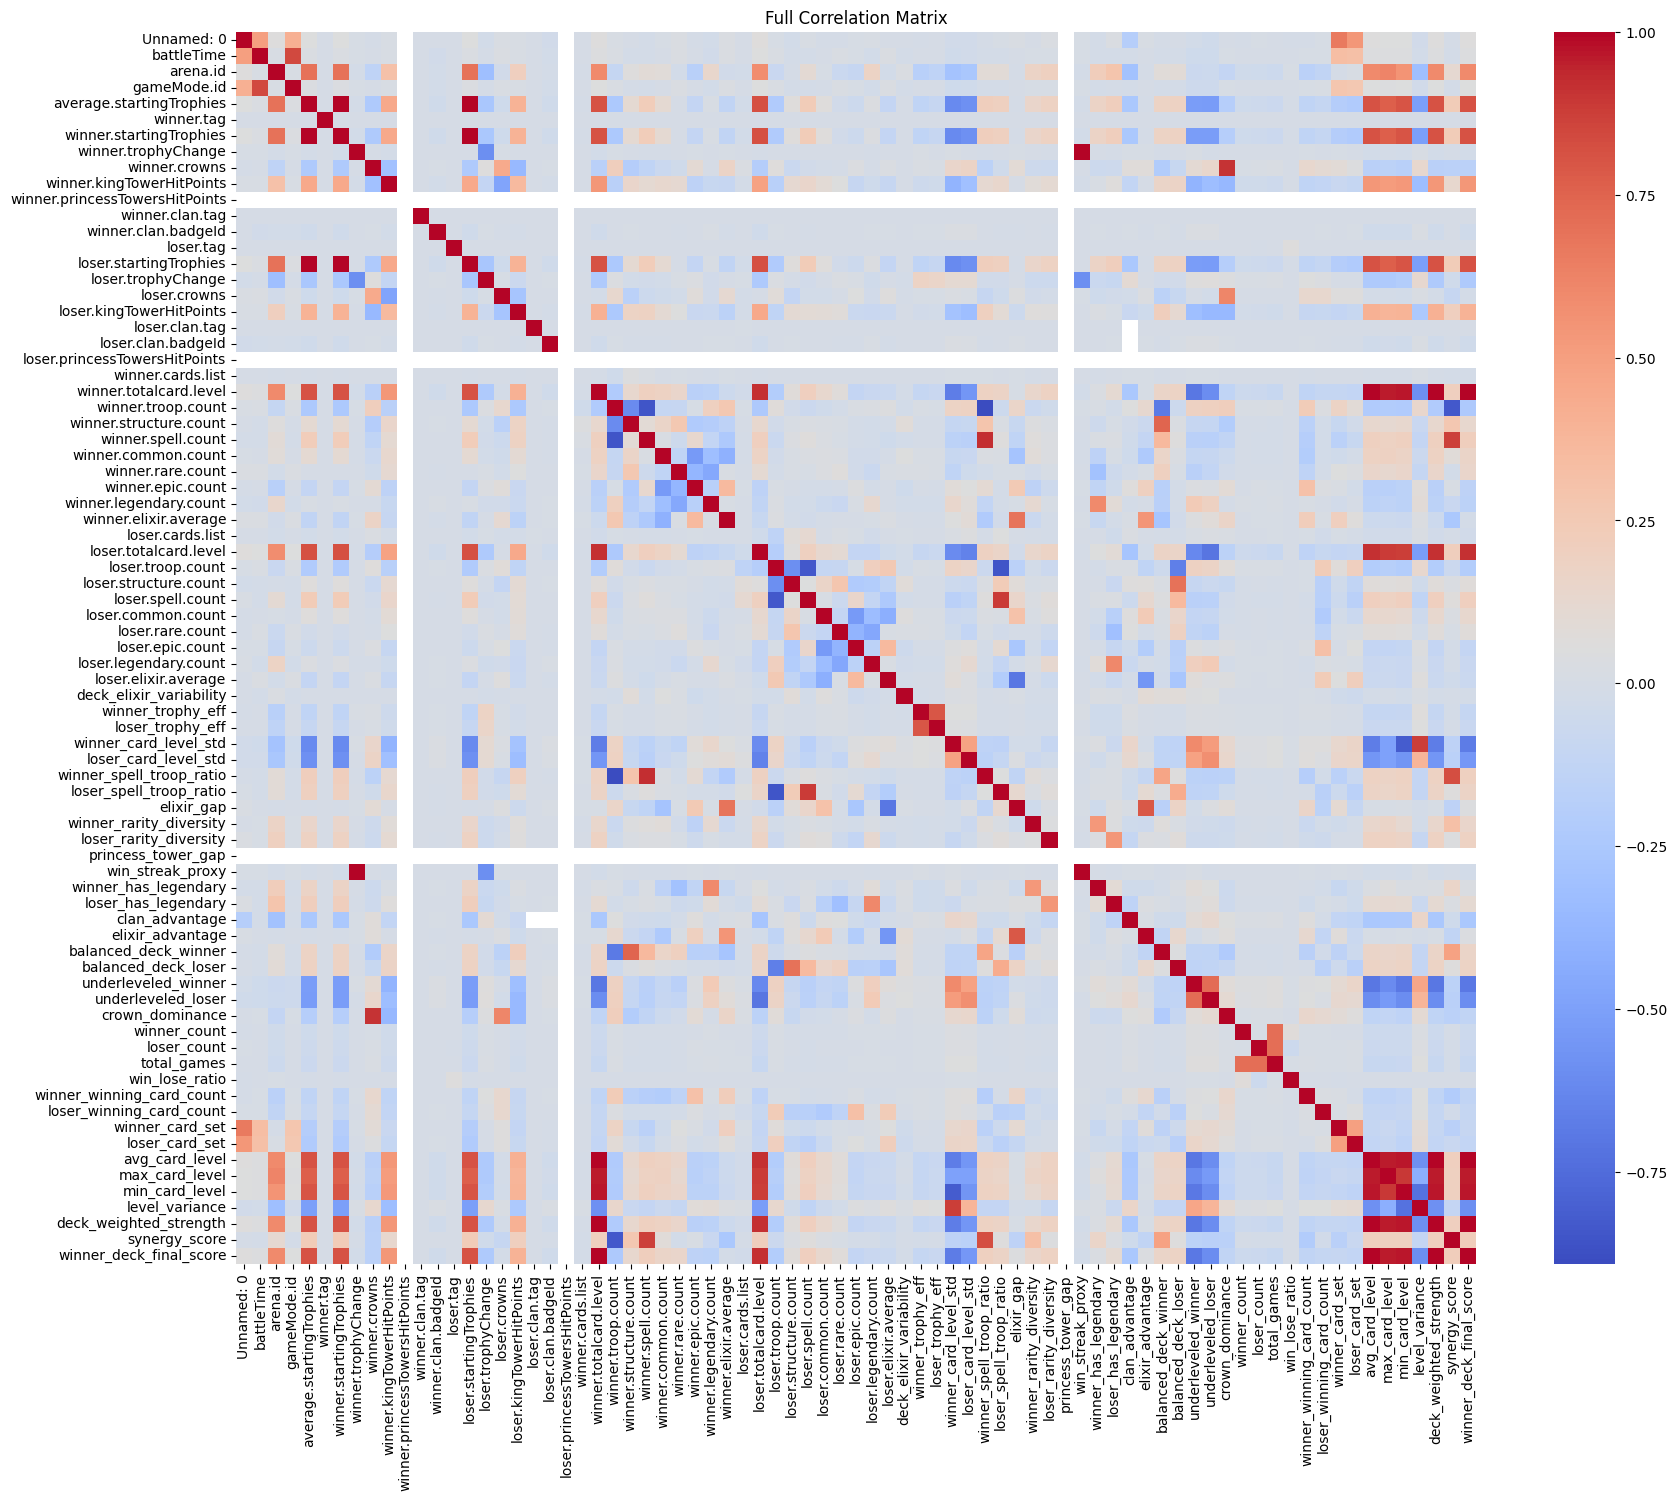

In [18]:
# Calculate the correlation matrix for the specified features
battles_df_for_dag = battles_df.copy()
battles_df_for_dag['loser_card_set'] = pd.factorize(battles_df_for_dag['loser_card_set'])[0]
battles_df_for_dag['winner_card_set'] = pd.factorize(battles_df_for_dag['winner_card_set'])[0]

correlation_matrix = battles_df_for_dag.corr()

plt.figure(figsize=(20, 16))
sns.heatmap(correlation_matrix, annot=False, cmap='coolwarm')
plt.title('Full Correlation Matrix')
plt.show()

now we will look at the feature-pairs that have more than 0.5 corr

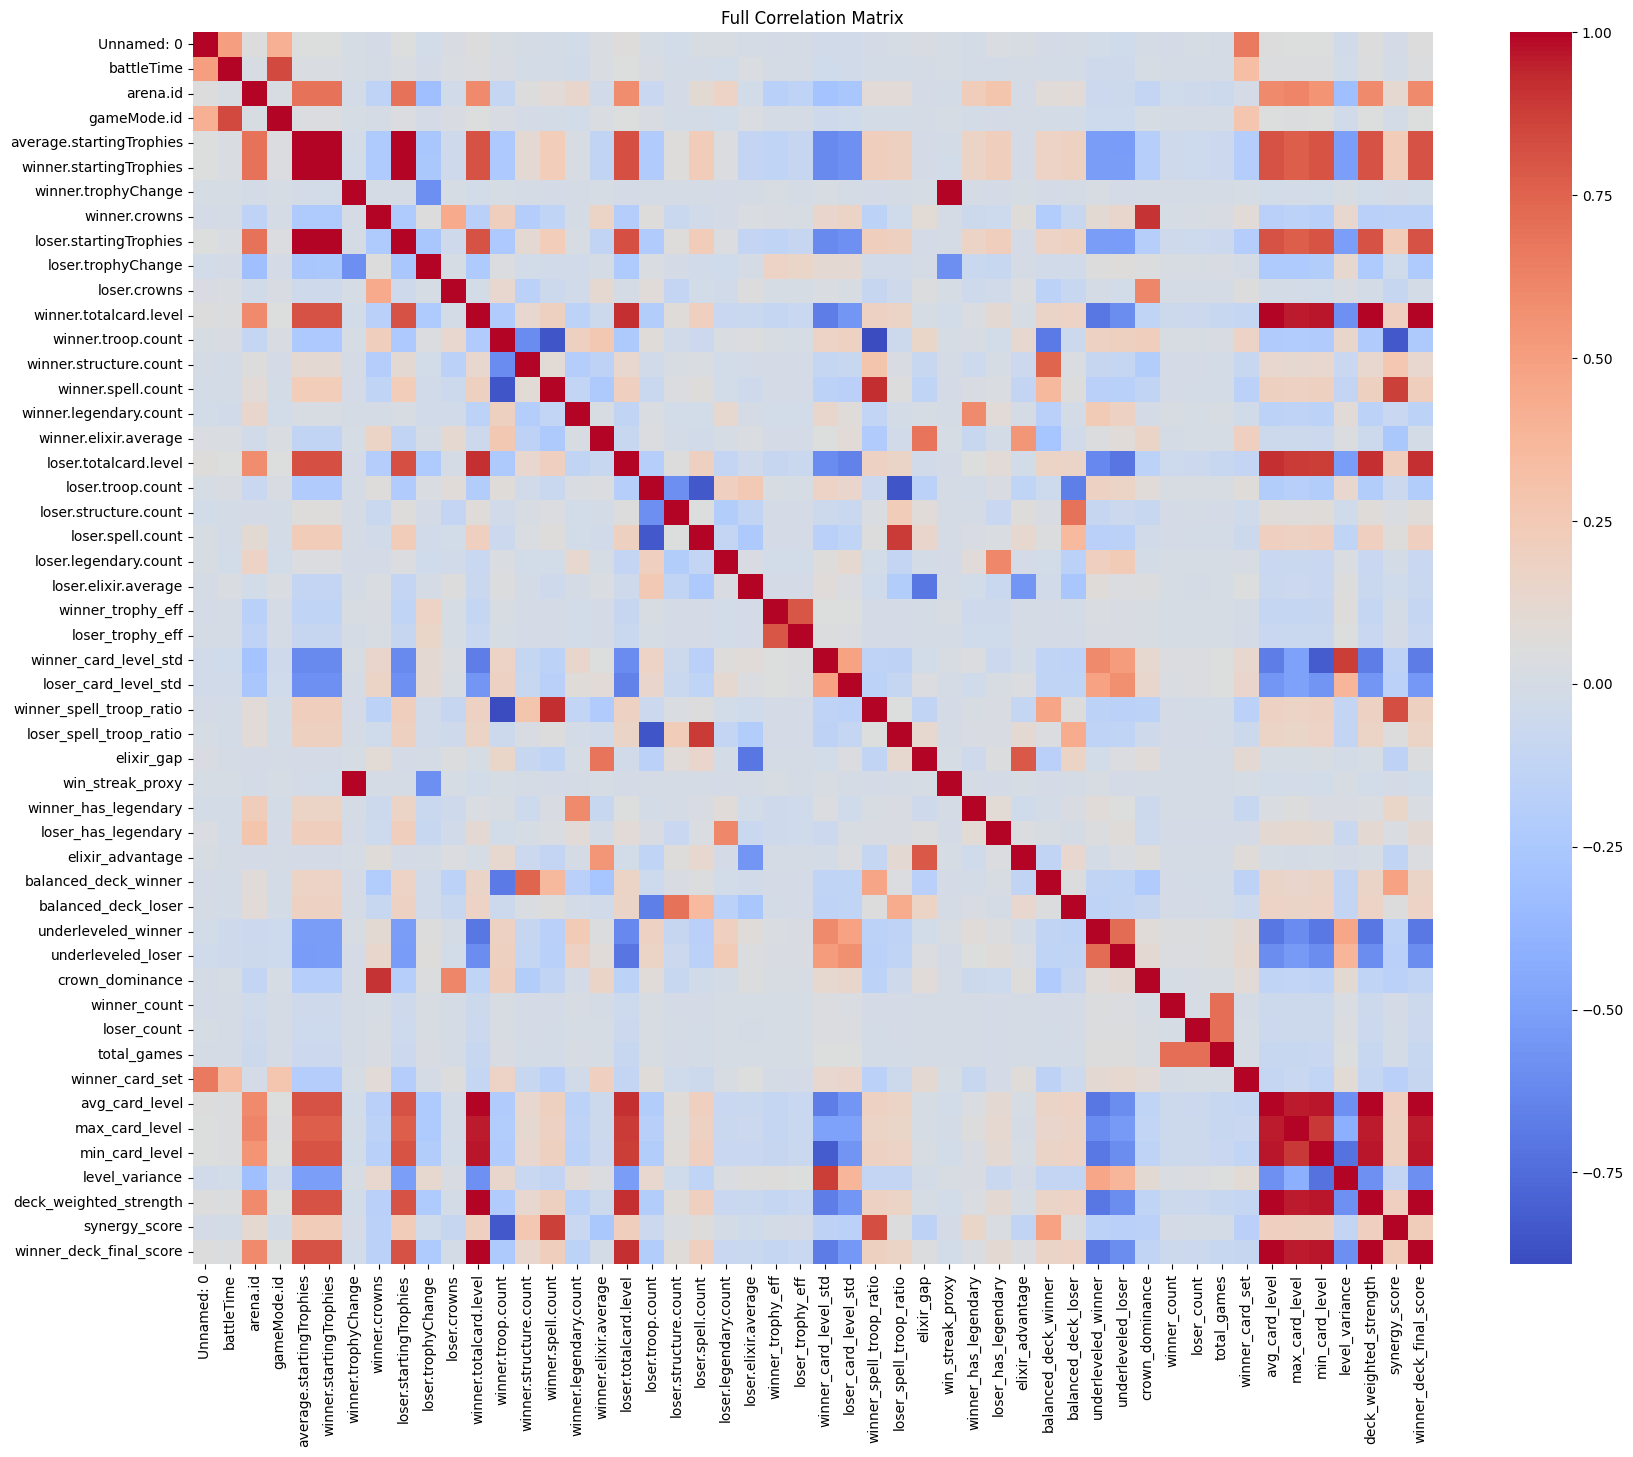

In [ ]:
potential_features = set()
# Iterate over the correlation matrix and print tuples with correlation >= 0.55
for i in range(len(correlation_matrix.columns)):
	for j in range(i+1, len(correlation_matrix.columns)):
		if abs(correlation_matrix.iloc[i, j]) > 0.55:
			potential_features.add(correlation_matrix.columns[i])
			potential_features.add(correlation_matrix.columns[j])

for feature in battles_df_for_dag.columns:
	if feature not in potential_features:
		battles_df_for_dag.drop(feature, axis=1, inplace=True)

correlation_matrix = battles_df_for_dag.corr()

plt.figure(figsize=(20, 16))
sns.heatmap(correlation_matrix, annot=False, cmap='coolwarm')
plt.title('Filtered Correlation Matrix')
plt.show()

### TODO: SALEH: ADD GRAPH AS SAID
### TODO: YAGEL AND RONI: add DAG per target features
### TODO: RONI: RUN PCA
### TODO: YAGEL: RUN UPDATED DAG
### TODO: YAGEL: UNDERSTAND WHAT TO DO WITH DAG
### DATELINE: 18/02 14:00